In [43]:
### Installing Required Packages

# ! pip install category_encoders
# ! pip install catboost

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import *
from sklearn.model_selection import *

import gc
from tqdm import tqdm_notebook
import category_encoders as ce
from functools import partial

from lightgbm import LGBMClassifier, LGBMRegressor

In [45]:
### The data provided by Zindi
BASE_PATH = '../input/usaid-contraceptive/USAID Contraceptive/USAID Contraceptive/'


contraceptive_case_data_annual = pd.read_csv(BASE_PATH + 'contraceptive_case_data_annual.csv')
train = pd.read_csv(BASE_PATH + 'Train.csv')
product = pd.read_csv(BASE_PATH + 'product.csv')
monthly_cases = pd.read_csv(BASE_PATH + 'monthly_cases.csv')
annual_cases = pd.read_csv(BASE_PATH + 'annual_cases.csv')
service_delivery_site_data = pd.read_csv(BASE_PATH + 'service_delivery_site_data.csv')
ss = pd.read_csv(BASE_PATH + 'SampleSubmission.csv')

In [46]:
### Get sum, mean and std of stock distributed for each site and product

train['sum_stock_distributed_for_product'] = train.groupby(['year', 'month', 'product_code'])['stock_distributed'].transform('sum')
train['mean_stock_distributed_for_product'] = train.groupby(['year', 'month', 'product_code'])['stock_distributed'].transform('mean')
train['std_stock_distributed_for_product'] = train.groupby(['year', 'month', 'product_code'])['stock_distributed'].transform('std')

train['sum_stock_distributed_for_site'] = train.groupby(['year', 'month', 'site_code'])['stock_distributed'].transform('sum')
train['mean_stock_distributed_for_site'] = train.groupby(['year', 'month', 'site_code'])['stock_distributed'].transform('mean')
train['std_stock_distributed_for_site'] = train.groupby(['year', 'month', 'site_code'])['stock_distributed'].transform('std')

In [47]:
features = [c for c in train.columns  if c not in ['year', 'month', 'region', 'district', 'site_code', 'product_code']]
train = train.sort_values(by = ['site_code', 'product_code', 'year', 'month'])

train['ds'] = pd.to_datetime(train['year'].astype('str') + '-' + train['month'].astype('str') + '-01', format = '%Y-%m-%d')
train['days_since_start'] = (train['ds'] - train['ds'].min()).dt.days
site_prod_dss = train.groupby(['site_code', 'product_code'])['days_since_start'].min()
prod_dss = train.groupby(['product_code'])['days_since_start'].min()

train = train.drop(['ds', 'days_since_start'], axis=1)

In [48]:
region_mapper = train.groupby('site_code')['region'].apply(lambda x: x.values[0])
district_mapper = train.groupby('site_code')['region'].apply(lambda x: x.values[0])

In [49]:
year = pd.DataFrame({'key' : 0, 'year': train['year'].unique()})
month = pd.DataFrame({'key' : 0, 'month': train['month'].unique()})
site_code = pd.DataFrame({'key' : 0, 'site_code': train['site_code'].unique()})
product_code = pd.DataFrame({'key': 0, 'product_code': train['product_code'].unique()})

year_month = pd.merge(year, month, on = 'key', how = 'left')
site_code_product_code = pd.merge(site_code, product_code, on = 'key', how = 'left')
all_combs = pd.merge(year_month, site_code_product_code, on = 'key', how = 'left')
all_combs = all_combs.drop('key', axis=1)
all_combs = all_combs.sort_values(by = ['year', 'month']).reset_index(drop = True)
all_combs['ID'] = all_combs['year'].astype('str') + ' X ' + all_combs['month'].astype('str') + ' X ' + all_combs['site_code'].astype('str') + ' X ' + all_combs['product_code'].astype('str')

train['ID'] = train['year'].astype('str') + ' X ' + train['month'].astype('str') + ' X ' + train['site_code'].astype('str') + ' X ' + train['product_code'].astype('str')
all_combs = pd.merge(all_combs, train, on = ['year', 'month', 'site_code', 'product_code', 'ID'], how = 'left')

In [50]:
df = all_combs.copy()

df['product_code_site_code_nunique'] = df['product_code'].map(train.groupby('product_code')['site_code'].nunique())
df['site_code_product_code_nunique'] = df['product_code'].map(train.groupby('site_code')['product_code'].nunique())

df = pd.merge(df, site_prod_dss.rename('first_day_of_product_site_code'), on = ['site_code', 'product_code'], how = 'left')
df = pd.merge(df, prod_dss.rename('first_day_of_product_code'), on = ['product_code'], how = 'left')

df['region'] = df['site_code'].map(region_mapper)
df['district'] = df['site_code'].map(district_mapper)

df['site_code_product_code'] = df['site_code'].astype('str') + df['product_code'].astype('str')

fts = [c for c in service_delivery_site_data.columns if c not in ['site_code', 'site_latitude', 'site_longitude']]
service_delivery_site_data[fts] = service_delivery_site_data[fts].apply(lambda x: pd.factorize(x)[0])
df = pd.merge(df, service_delivery_site_data, on = 'site_code', how = 'left')

In [51]:
### All these features can be used as lag features, or we can use their values N months back to predict the target

lag_fts = ['stock_initial', 'stock_received', 'stock_distributed',
       'stock_adjustment', 'stock_end', 'average_monthly_consumption',
       'stock_stockout_days', 'stock_ordered','implant_women_old',
       'implant_women_new', 'injection2_women_old', 'injection2_women_new',
       'injection3_women_old', 'injection3_women_new', 'pill_women_old',
       'pill_women_new', 'iud_women_old', 'iud_women_new',
       'iud_number_dispensed', 'implant_number_dispensed',
       'injection2_number_dispensed', 'injection3_number_dispensed',
       'pill_number_dispensed', 'iud_number_received',
       'implant_number_received', 'injection2_number_received',
       'injection3_number_received', 'pill_number_received', 'iud_stock_end',
       'implant_stock_end', 'injection2_stock_end', 'injection3_stock_end',
       'pill_stock_end','sum_stock_distributed_for_product', 'mean_stock_distributed_for_product',
           'std_stock_distributed_for_product','sum_stock_distributed_for_site', 'mean_stock_distributed_for_site',
           'std_stock_distributed_for_site','sum_stock_distributed_for_district', 'mean_stock_distributed_for_district',
           'std_stock_distributed_for_district'
          ]

lag_fts = [c for c in lag_fts if c in df.columns]

orig_cols = df.columns.tolist()
orig_cols = [c for c in orig_cols if c not in ['year','month','region','district','site_code', 'site_code_product_code',
                                              'first_day_of_product_site_code', 'first_day_of_product']]

In [52]:
#### Starting 3 months back since we need to predict 3 months in advance

for i in tqdm_notebook(range(3, 25)):
    
    ### Shift lag_features i months back
    new_df = df[lag_fts + ['site_code_product_code']].groupby('site_code_product_code')[lag_fts].shift(i)
    
    ### Shift lag_features i + 1 months back
    new_df2 = df[lag_fts + ['site_code_product_code']].groupby('site_code_product_code')[lag_fts].shift(i+1)
    
    ### Shift lag_features i + 2 months back
    new_df3 = df[lag_fts + ['site_code_product_code']].groupby('site_code_product_code')[lag_fts].shift(i+2)
    
    
    ### Getting the difference between (i) and (i + 1) months back
    new_df2 = new_df - new_df2
    
    ### Getting the difference between (i) and (i + 2) months back
    new_df3 = new_df - new_df3
    
    new_df.columns = [c + f'_{i}_months_back' for c in new_df.columns]
    new_df2.columns = [c + f'_{i}_months_back_diff_to_prev_month_1' for c in new_df2.columns]
    new_df3.columns = [c + f'_{i}_months_back_diff_to_prev_month_2' for c in new_df3.columns]
    
    
    df = pd.concat([df, new_df, new_df2, new_df3], axis=1).reset_index(drop = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
### Converting Strings to numbers

cat_cols = ['site_code', 'product_code', 'region', 'district', 'site_code_product_code']
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

In [54]:
train = df[df['ID'].isin(train['ID'])].reset_index(drop = True)
test = df[df['ID'].isin(ss['ID'])].reset_index(drop = True)

In [55]:
ID_COL, TARGET_COL = 'ID', 'stock_distributed'

In [56]:
preds_df = pd.DataFrame()

for i, enc2 in tqdm_notebook(enumerate([ce.JamesSteinEncoder, ce.TargetEncoder, ce.MEstimateEncoder])):
    
    enc = partial(enc2, cols = ['site_code', 'product_code', 'district', 'region', 'site_code_product_code'])()
    trn, val = train_test_split(train, test_size = 0.1,random_state = 0)

    trn = enc.fit_transform(trn, trn[TARGET_COL]).sample(frac = 1, random_state = 0)
    val = enc.transform(val)
    tst = enc.transform(test)
    
    fts = [c for c in trn.columns if c not in [ID_COL, TARGET_COL] + orig_cols]
    
    clf = LGBMRegressor(n_estimators=200, colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=0.5, learning_rate=0.03)
    clf.fit(trn[fts], trn[TARGET_COL])

    preds_df[i] = clf.predict(tst[fts])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


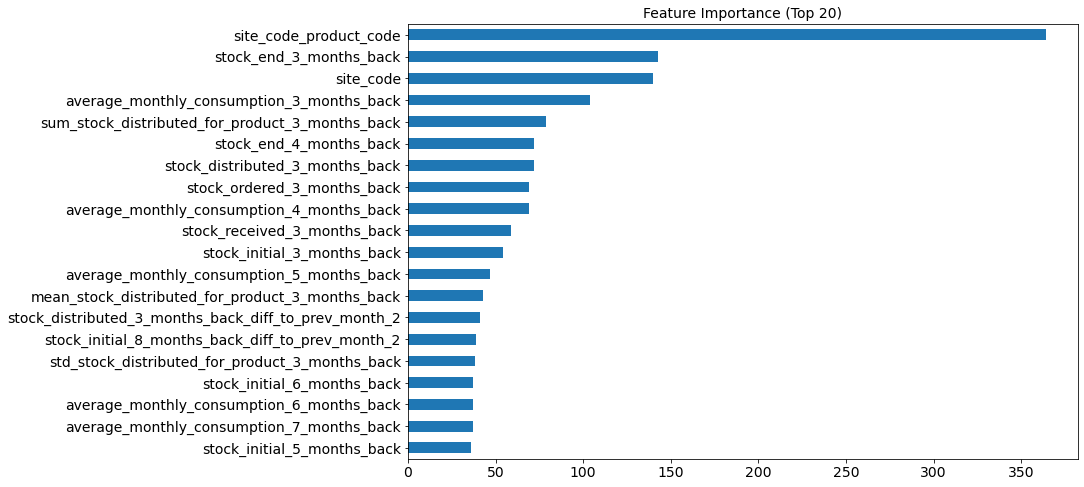

In [57]:
fi = pd.Series(index = fts, data = clf.feature_importances_)
_ = fi.sort_values(ascending = False)[:20][::-1].plot(kind = 'barh', figsize=(12, 8), fontsize=14)
_ = plt.title('Feature Importance (Top 20)', fontsize = 14)

In [58]:
preds = preds_df.mean(axis=1)
preds[preds < 0] = 0

## Multiply by a factor to include trend
test['prediction'] = preds * 1.12

In [59]:
ss_new = pd.merge(ss[['ID']], test[['ID', 'prediction']], on = 'ID', how = 'left')
ss_new = ss_new.fillna(0)
ss_new.to_csv('ss_idag.csv', index=False)

In [60]:
ss_new.head(10)

,ID,prediction
0,2019 X 7 X C4001 X AS21126,0.456293
1,2019 X 7 X C4001 X AS27134,19.944806
2,2019 X 7 X C4001 X AS27132,0.494013
3,2019 X 7 X C4001 X AS27000,11.935948
4,2019 X 7 X C4001 X AS27137,2.509583
5,2019 X 7 X C4001 X AS27138,3.841896
6,2019 X 7 X C4001 X AS27133,28.886750
7,2019 X 7 X C4023 X AS27000,16.265089
8,2019 X 7 X C4023 X AS27133,43.185304
9,2019 X 8 X C4023 X AS27000,15.673665


In [61]:
ss_new.tail(10)

,ID,prediction
3079,2019 X 9 X C2055 X AS27139,1.341042
3080,2019 X 9 X C2055 X AS27137,2.120408
3081,2019 X 9 X C2055 X AS27138,6.545205
3082,2019 X 9 X C2055 X AS27133,27.808278
3083,2019 X 9 X C5076 X AS27132,0.000000
3084,2019 X 9 X C5076 X AS27000,0.000000
3085,2019 X 9 X C5076 X AS27139,0.000000
3086,2019 X 9 X C5076 X AS27137,0.000000
3087,2019 X 9 X C5076 X AS27138,0.000000
3088,2019 X 9 X C5076 X AS27133,0.000000
